# Ames Housing EDA
This notebook explores the Ames Housing dataset to identify trends, relationships, and data quality issues in preparation for feature engineering and modeling.

In [239]:
# NOTE: Dropped rows with missing values in low-null columns (1–2 missing total)
#       Will revisit this strategy if we choose to impute later on

### Import Statements

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [241]:
df = pd.read_csv('../data/AmesHousing.csv')

# Create a copy of preprocessed data
df_og = df.copy()

### Initial Overview

In [242]:
print(df.shape)
print(df.info())
print(df.head())

(2930, 82)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  Hou

## Data Cleaning

### Check for Duplicate and Missing Values

In [249]:
# Duplicates
print("Number of duplicate rows:", df.duplicated().sum(), "\n")

# Missing Values
print("Number of missing values per column (non-zero):")
num_missing = df.isnull().sum()
print(num_missing[num_missing > 0].to_string())

# Remove rows corresponding to columns that have only 1 or 2 missing values
low_null_cols = df.columns[df.isnull().sum().between(1, 2)]
df = df.dropna(subset=low_null_cols)

# Print unique non-null values for other columns with missing values
high_null_cols = df.columns[df.isnull().sum() > 2]
for col in high_null_cols:
    print(f"\n{col} - missing: {df[col].isnull().sum()}")
    print(df[col].dropna().unique())

# Validate if null values should be filled
print(df[df['Fireplace Qu'].isnull()]['Fireplaces'].value_counts())
print(df[df['Pool QC'].isnull()]['Pool Area'].value_counts())
print(df[df['Misc Feature'].isnull()]['Misc Val'].value_counts())
print(df[df['Mas Vnr Type'].isnull()][['Mas Vnr Area']].value_counts())
print(df[df['Garage Type'].isnull()]['Garage Area'].value_counts())

# Get rows where Garage Type is NOT null but at least one other garage col IS null
garage_cols = ['Garage Yr Blt', 'Garage Finish', 'Garage Qual', 'Garage Cond']
mask = df['Garage Type'].notnull() & df[garage_cols].isnull().any(axis=1)
print(df[mask][['Garage Type'] + garage_cols + ['Garage Cars', 'Garage Area']])

# Define basement-related columns and identify rows with partially missing basement info
basement_cols = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
partial_missing_basement = df[basement_cols].isnull().any(axis=1) & ~df[basement_cols].isnull().all(axis=1)

Number of duplicate rows: 0 

Number of missing values per column (non-zero):
Series([], )
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Empty DataFrame
Columns: [Garage Type, Garage Yr Blt, Garage Finish, Garage Qual, Garage Cond, Garage Cars, Garage Area]
Index: []


### Treat Missing Values

In [248]:
# Replace null values with 'None' or 0 where appropriate
df['Fireplace Qu'] = df['Fireplace Qu'].fillna('None')
df['Pool QC'] = df['Pool QC'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['Misc Feature'] = df['Misc Feature'].fillna('None')
df['Alley'] = df['Alley'].fillna('None')

# Set Mas Vnr Type to 'None' only if area is 0, otherwise 'Unknown'
# and drop the row if Mas Vnr Type and Mas Vnr Area are both unknown
df.loc[(df['Mas Vnr Type'].isnull()) & (df['Mas Vnr Area'] == 0), 'Mas Vnr Type'] = 'None'
df.loc[(df['Mas Vnr Type'].isnull()) & (df['Mas Vnr Area'] != 0), 'Mas Vnr Type'] = 'Unknown'
df = df[~((df['Mas Vnr Type'] == 'Unknown') & (df['Mas Vnr Area'].isnull()))]

# Fill remaining garage-related missing values
# and drop the one garage row with missing qualitative info
garage_fill_cols = ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']
df[garage_fill_cols] = df[garage_fill_cols].fillna('None')
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(0)

# Drop basement rows with partial missing info and fill rest
basement_cols = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
partial_missing_basement = df[basement_cols].isnull().any(axis=1) & ~df[basement_cols].isnull().all(axis=1)
df = df[~partial_missing_basement]
df[basement_cols] = df[basement_cols].fillna('None')

# Impute Lot Frontage with neghborhood median and drop remaining rows
df['Lot Frontage'] = df.groupby('Neighborhood')['Lot Frontage'].transform(
    lambda x: x.fillna(x.median()) if x.notna().sum() > 0 else x
)
df['Lot Frontage'] = df['Lot Frontage'].fillna(df['Lot Frontage'].median())

## Visualization

### Distribution of Sale Prices

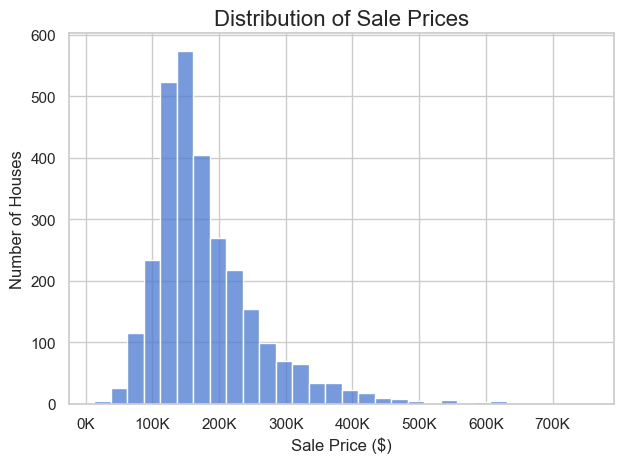

count      2899.00
mean     180328.81
std       79840.40
min       12789.00
25%      129000.00
50%      160000.00
75%      213000.00
max      755000.00
Name: SalePrice, dtype: float64


In [245]:
from matplotlib.ticker import FuncFormatter

# Set theme
sns.set_theme(style="whitegrid", palette="muted", context="notebook")

# Plot SalePrice histogram
sns.histplot(df['SalePrice'], bins = 30)
plt.title('Distribution of Sale Prices', fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
plt.xlabel('Sale Price ($)', fontsize=12)
plt.ylabel('Number of Houses', fontsize=12)
plt.tight_layout()
plt.show()

# Summary statistics for Sale Price
print(df['SalePrice'].describe().round(2))

### Correlation of Numeric Features with SalePrice

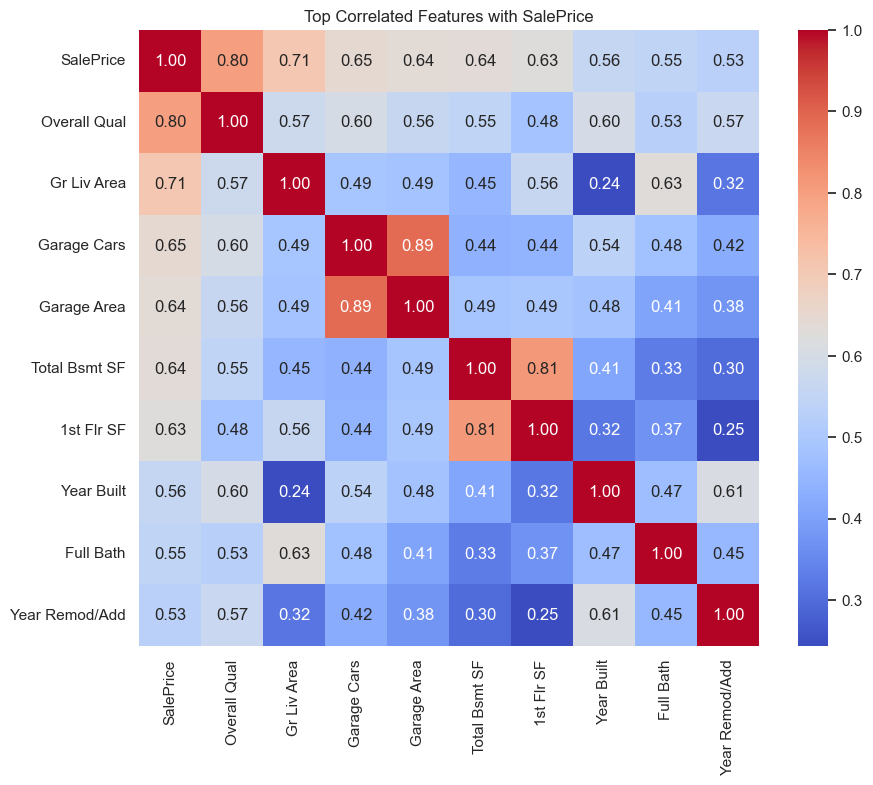

In [246]:
# Calculate correlations with SalePrice
corr = df.corr(numeric_only=True)
top_corr_features = corr['SalePrice'].abs().sort_values(ascending=False).head(10).index  # Top 10 features

# Heatmap of top correlated features
plt.figure(figsize=(10,8))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top Correlated Features with SalePrice')
plt.show()